In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
import seaborn as sns
import glob
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = './dataset/Training'
test =  './dataset/Testing'

In [3]:
image_shape = []
def check_image(path):
    image = cv2.imread(path)
    if image.shape not in image_shape:
        image_shape.append(image.shape)

images = glob.glob(f"{train}/*/*", recursive=True)
for i in images:
    if ".DS_Store" not in i:
        check_image(i)

print(f"Total: {len(image_shape)}")

Total: 382


In [4]:
print(len(images))

5712


In [5]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range =0.2,
                                   zoom_range = 0.1,
                                   horizontal_flip=True,
                                   vertical_flip = True,
                                   validation_split=0.2)
train_set = train_datagen.flow_from_directory(train,
                                              target_size = (512,512),
                                              batch_size=32,
                                              class_mode='categorical',
                                              subset='training')
validation_set = train_datagen.flow_from_directory(train,
                                              target_size = (512,512),
                                              batch_size=32,
                                              class_mode='categorical',
                                              subset='validation')

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


In [6]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test,
                                            target_size=(512,512),
                                            batch_size=32,
                                            class_mode='categorical')

Found 1311 images belonging to 4 classes.


In [7]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

In [8]:
def residual_block(input, filters, stride=1):
    x = layers.Conv2D(filters, kernel_size=(3,3), strides=stride, padding='same')(input)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, kernel_size=(3,3) ,strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    shortcut = input
    if stride != 1 or x.shape[-1] != shortcut.shape[-1]:
        shortcut = layers.Conv2D(filters, (1,1), strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)

    return x

#Using resnet34
def model(input_size=(512,512,3), num_classes=4):
    inputs = layers.Input(shape=input_size)

    x = layers.Conv2D(64, kernel_size=(7,7), strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(x)

    #Stage 1
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    
    # Stage 2
    x = residual_block(x, 128, stride=2)  
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    
    # Stage 3
    x = residual_block(x, 256, stride=2) 
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    
    # Stage 4
    x = residual_block(x, 512, stride=2)  
    x = residual_block(x, 512)
    x = residual_block(x, 512)

    x = layers.GlobalAveragePooling2D()(x)
    output = layers.Dense(num_classes, activation='softmax')(x) #use softmax bc multiclass

    model = Model(inputs, output)
    return model

In [9]:
resnet34 = model()
resnet34.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
callbacks = ModelCheckpoint('./trained_model/resnet34_brain.keras')

In [10]:
#Use this to train, otherwise use load model
"""history = resnet34.fit(train_set, epochs=20, validation_data = validation_set,
                    verbose=1, callbacks= callbacks)"""

'history = resnet34.fit(train_set, epochs=20, validation_data = validation_set,\n                    verbose=1, callbacks= callbacks)'

In [11]:
from keras.saving import load_model

resnet_model = load_model('../trained_model/resnet34_brain.keras')

In [12]:
# Assuming `model` is your trained model
loss, accuracy = resnet_model.evaluate(test_set)
print(f"Test accuracy: {accuracy * 100:.2f}%")

I0000 00:00:1731570970.830878 5559258 service.cc:146] XLA service 0x330a264d0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731570970.830940 5559258 service.cc:154]   StreamExecutor device (0): Host, Default Version
2024-11-14 18:56:10.863506: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731570971.344572 5559258 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


41/41 ━━━━━━━━━━━━━━━━━━━━ 161s 4s/step - accuracy: 0.9360 - loss: 0.1791
Test accuracy: 93.14%


In [13]:
classes = train_set.class_indices
classes_swapped = {value : key for key, value in classes.items()}
classes_swapped

{0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}

In [52]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import random

img_path = glob.glob(f"{test}/*/*")
test_image = random.choice(img_path)
actual_class = test_image.split("/")[-2]
actual_class

'glioma'

In [53]:
img = load_img(test_image, target_size=(512,512))
img_array = img_to_array(img)
img_array = img_array/255.0
img_array = np.expand_dims(img_array, axis=0)
pred = resnet_model.predict(img_array)
predicted_class = np.argmax(pred, axis=1)
print(f"Predicted class: {classes_swapped[predicted_class[0]]}, Actual class: {actual_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Predicted class: glioma, Actual class: glioma


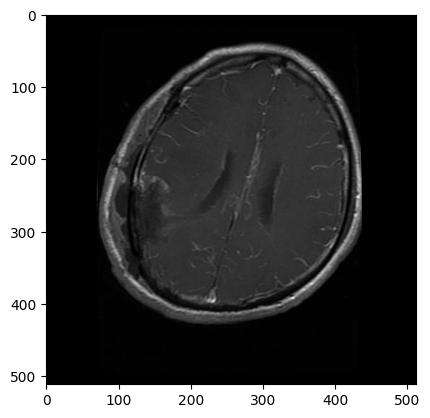

In [54]:
plt.imshow(img_array[0], cmap='gray')

In [55]:
for layer in resnet_model.layers:
    print(layer.name)

input_layer
conv2d
batch_normalization
re_lu
max_pooling2d
conv2d_1
batch_normalization_1
re_lu_1
conv2d_2
batch_normalization_2
add
re_lu_2
conv2d_3
batch_normalization_3
re_lu_3
conv2d_4
batch_normalization_4
add_1
re_lu_4
conv2d_5
batch_normalization_5
re_lu_5
conv2d_6
batch_normalization_6
add_2
re_lu_6
conv2d_7
batch_normalization_7
re_lu_7
conv2d_8
conv2d_9
batch_normalization_8
batch_normalization_9
add_3
re_lu_8
conv2d_10
batch_normalization_10
re_lu_9
conv2d_11
batch_normalization_11
add_4
re_lu_10
conv2d_12
batch_normalization_12
re_lu_11
conv2d_13
batch_normalization_13
add_5
re_lu_12
conv2d_14
batch_normalization_14
re_lu_13
conv2d_15
batch_normalization_15
add_6
re_lu_14
conv2d_16
batch_normalization_16
re_lu_15
conv2d_17
conv2d_18
batch_normalization_17
batch_normalization_18
add_7
re_lu_16
conv2d_19
batch_normalization_19
re_lu_17
conv2d_20
batch_normalization_20
add_8
re_lu_18
conv2d_21
batch_normalization_21
re_lu_19
conv2d_22
batch_normalization_22
add_9
re_lu_20
conv

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


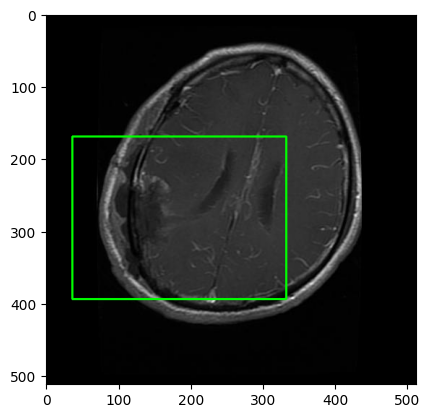

In [56]:
def get_gradcam_heatmap(model, image, class_idx, last_conv_layer_name):
    grad_model = tf.keras.models.Model(inputs=model.inputs, 
                                       outputs=[model.get_layer(last_conv_layer_name).output, 
                                        model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

heatmap = get_gradcam_heatmap(resnet_model, img_array, predicted_class[0], 'conv2d_34')
heatmap_resized = cv2.resize(heatmap, (512,512))
_, binarymask = cv2.threshold(heatmap_resized, 0.5, 1, cv2.THRESH_BINARY)
contours, _ = cv2.findContours((binarymask*255).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    cv2.rectangle(img_array[0], (x,y), (x+w,y+h), (0,255,0), 2)

plt.imshow(img_array[0])

In [57]:
from skimage import morphology, measure
from sklearn.cluster import KMeans

def normal_standard_image(image):
    row_size = image.shape[0]
    col_size = image.shape[1]
    mean = np.mean(image)
    print(mean)
    std = np.std(image)
    #subtracting mean centers the values around zero, help model learn image structure
    #result in black and white image of overall image structure?
    image = image-mean
    #standardization, to learn structural details 
    image = image/std

    return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


23.904799


Text(0.5, 1.0, 'Normalized and Standardized Image')

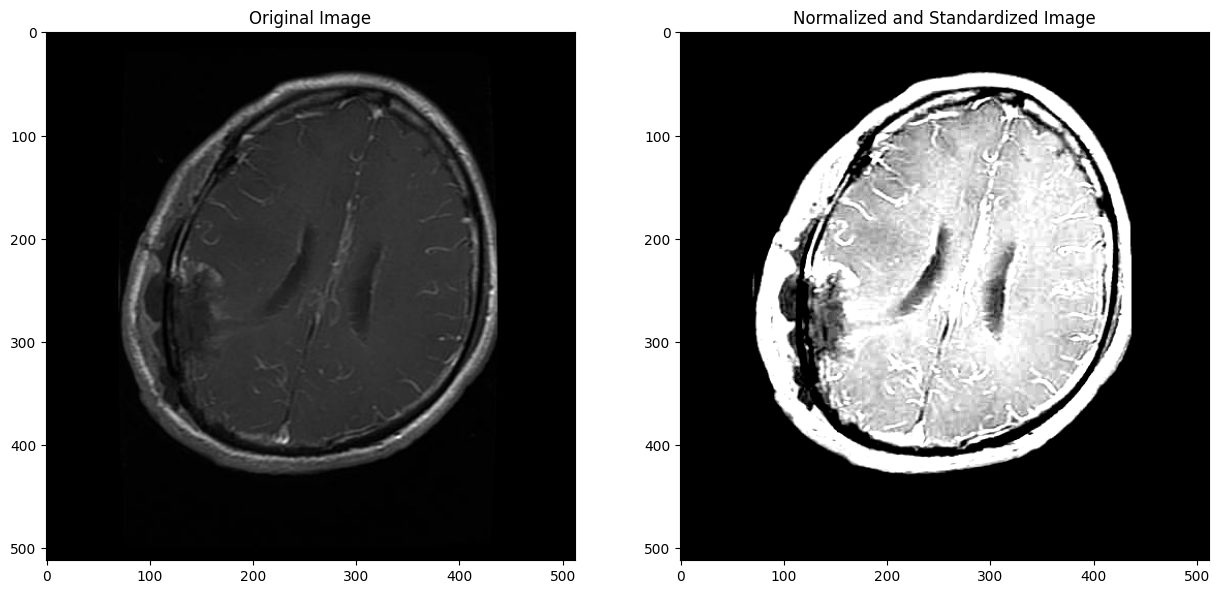

In [58]:
image_original = load_img(test_image, target_size=(512,512))
image_array = img_to_array(image_original)
image = normal_standard_image(image_array)

fig, ax = plt.subplots(1,2, figsize=(15,20))
ax[0].imshow(image_original)
ax[0].set_title('Original Image')
ax[1].imshow(image, cmap='gray')
ax[1].set_title('Normalized and Standardized Image')

In [59]:
def renormalized(image):
    #renormalizoing to include more image details
    row_size = image.shape[0]
    col_size = image.shape[1]
    image = normal_standard_image(image)
    middle = image[int(col_size/5):int(col_size/5*4), int(row_size/5):int(row_size/5*4)]
    mean = np.mean(middle)
    print(mean)

    #handling underflow and overflow prevents outliers from distorting thresholding and segmentation
    max = np.max(image)
    min = np.min(image)
    image[image==max] = mean
    image[image==min] = mean
    return image, middle, row_size, col_size

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


23.904799
0.819527


Text(0.5, 1.0, 'Renormalized Image')

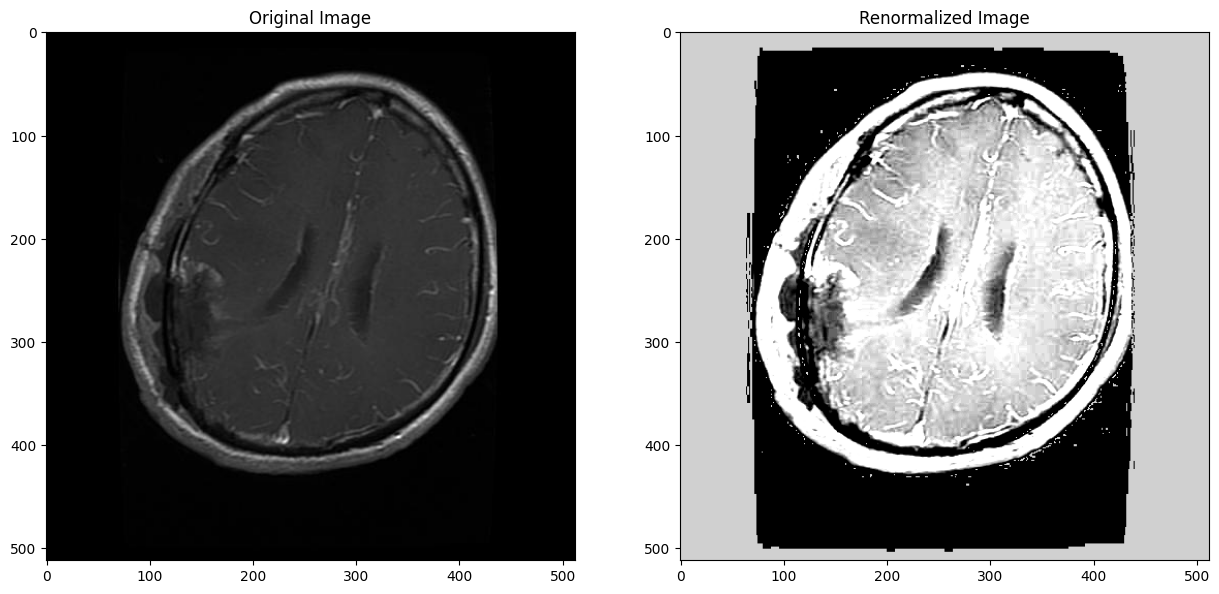

In [60]:
image = renormalized(image_array)[0]

fig, ax = plt.subplots(1,2, figsize=(15,20))
ax[0].imshow(image_original)
ax[0].set_title('Original Image')
ax[1].imshow(image)
ax[1].set_title('Renormalized Image')